In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

%cd "/home/marco/DTU/DG_project_course/"
data_path = "0_reset/data/"

/home/marco/DTU/DG_project_course


# 1. Dataset composition and infos 

Create a regex to divide the fasta headers in meaningful pieces 

In [4]:
pattern = re.compile(
    r'^(?P<id>\S+)\s*'                          
    r'(?P<predicted>PREDICTED:?\s*)?'           
    r'(?P<additional_info2>.*?)'         
    r'caspase[- ]?'                      
    r'(?P<caspase>(\d+|dronc)?)'         
    r'(?P<caspase_like>(-like)?)'               
    r'(?P<additional_info1>.*?)'                
    r'\[(?P<species>[^\]]+)\]',                 
    re.IGNORECASE
)

Create dictionary to hold the information from the headers

In [5]:
protein_info = {
    "id":[],
    "predicted":[],
    "caspase":[],
    "caspase_like":[],
    "additional_info":[],
    "species":[],
    "sequence":[]
}

Extract the entries of the fasta file and put into the dictionary (keep track of unmatched entries)

In [44]:
fasta_file = os.path.join(data_path, "all_caspase_seq.fasta")
unmatched = []
for record in SeqIO.parse(fasta_file, "fasta"):
    desc = record.description
    m = pattern.search(desc)
    if m:
        protein_info["id"].append(m.group('id'))
        protein_info["predicted"].append(1 if m.group("predicted") else 0)
        protein_info["caspase"].append(m.group('caspase') if m.group('caspase') else "Not_specified")
        protein_info["caspase_like"].append(1 if m.group("caspase_like") else 0)
        protein_info["additional_info"].append(f"{m.group('additional_info1')} {m.group('additional_info2')}".strip())
        protein_info["species"].append(m.group('species').replace(" ", "_"))
        protein_info["sequence"].append(str(record.seq))
    else:
        unmatched.append(desc)

print(f"Found {len(unmatched)} unmatched sequences")
for i in unmatched: print(i)

Found 1 unmatched sequences
XP_003108285.1 CRE-CED-3 protein [Caenorhabditis remanei]


Make the dictionary into a dataframe

In [45]:
df = pd.DataFrame(protein_info)
df["len"] = df["sequence"].str.len()
df["contains_unknown_aa"] = df["sequence"].str.contains("X")
df.head()

,id,predicted,caspase,caspase_like,additional_info,species,sequence,len,contains_unknown_aa
0,NP_001260718.1,0,Not_specified,0,", isoform B Ser/Thr-rich",Drosophila_melanogaster,MGWWSKKSETDRSQPSQELVAQDPRTRVQTTSAATETTNTAVQNST...,527,False
1,NP_001303345.1,0,Not_specified,0,", isoform B death associated molecule related...",Drosophila_melanogaster,MYLPERTEHQKIERLYDSNRVNAEPGQGLDLNEKLKPPAVYILNHE...,255,False
2,NP_476974.1,0,1,0,death,Drosophila_melanogaster,MTDECVTRNYGVGIRSPNGSENRGSFIMADNTDAKGCTPESLVVGG...,323,False
3,NP_477249.3,0,Not_specified,0,", isoform E death related ced-3/Nedd2-like",Drosophila_melanogaster,MAGSNLLIHLDTIDQNDLIYVERDMNFAQKVGLCFLLYGDDHSDAT...,494,False
4,NP_477462.1,0,Not_specified,0,related to Apopain/Yama death executioner,Drosophila_melanogaster,MDDTDFSLFGQKNKHKKDKADATKIAHTPTSELDLKRIIISRPTNE...,308,False


Reorder the columns

In [46]:
cols = ["id", "len", "species", "predicted", "caspase", "caspase_like", "contains_unknown_aa", "additional_info", "sequence"]
df = df[cols]
df.head()

,id,len,species,predicted,caspase,caspase_like,contains_unknown_aa,additional_info,sequence
0,NP_001260718.1,527,Drosophila_melanogaster,0,Not_specified,0,False,", isoform B Ser/Thr-rich",MGWWSKKSETDRSQPSQELVAQDPRTRVQTTSAATETTNTAVQNST...
1,NP_001303345.1,255,Drosophila_melanogaster,0,Not_specified,0,False,", isoform B death associated molecule related...",MYLPERTEHQKIERLYDSNRVNAEPGQGLDLNEKLKPPAVYILNHE...
2,NP_476974.1,323,Drosophila_melanogaster,0,1,0,False,death,MTDECVTRNYGVGIRSPNGSENRGSFIMADNTDAKGCTPESLVVGG...
3,NP_477249.3,494,Drosophila_melanogaster,0,Not_specified,0,False,", isoform E death related ced-3/Nedd2-like",MAGSNLLIHLDTIDQNDLIYVERDMNFAQKVGLCFLLYGDDHSDAT...
4,NP_477462.1,308,Drosophila_melanogaster,0,Not_specified,0,False,related to Apopain/Yama death executioner,MDDTDFSLFGQKNKHKKDKADATKIAHTPTSELDLKRIIISRPTNE...


Visualize some infos of the dataset

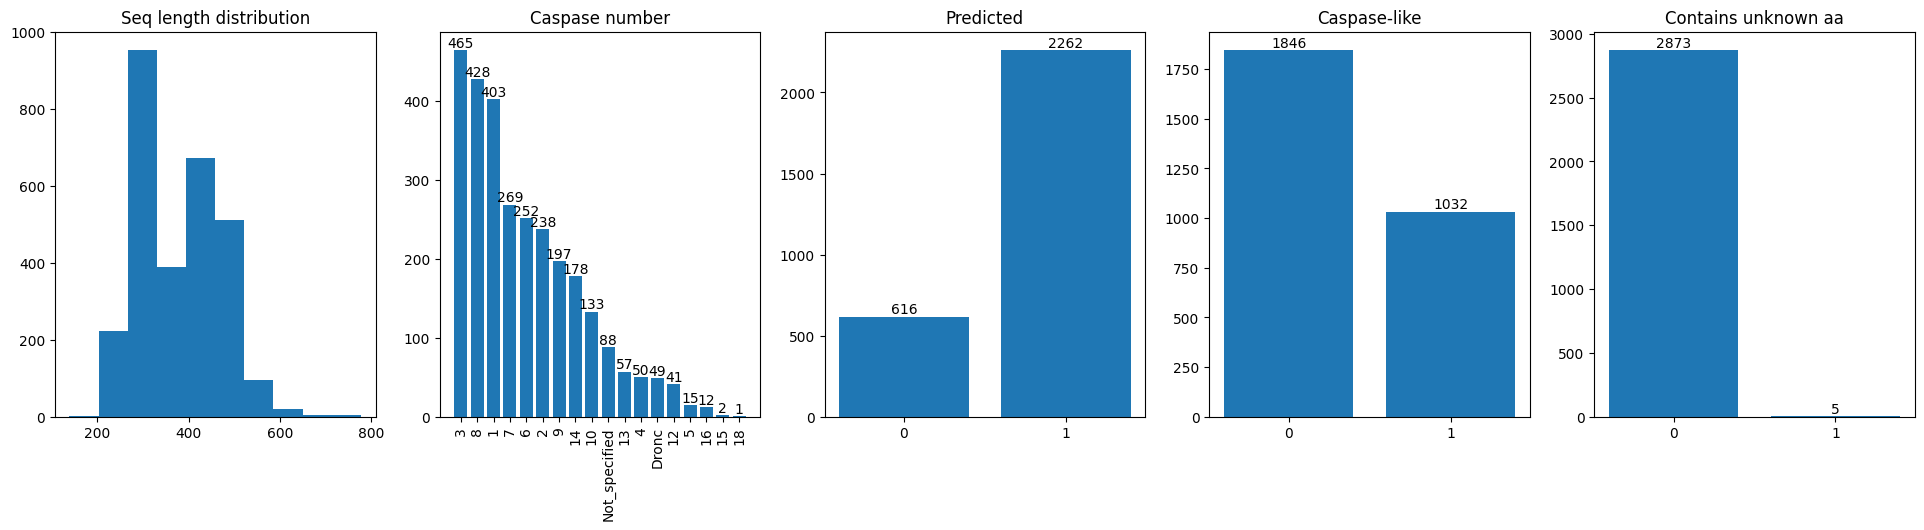

In [47]:
def plot_infos(df):
    fig, axs = plt.subplots(1,5, figsize=(24,5))
    # 0. Lenght 
    axs[0].set_title("Seq length distribution")
    axs[0].hist(df["len"])

    # 1. Caspase number
    counts = df["caspase"].value_counts()
    counts = counts.sort_values(ascending=False) 
    bars = axs[1].bar(range(len(counts.index)), counts.values)
    axs[1].set_title("Caspase number")
    axs[1].set_xticks(range(len(counts.index)))
    axs[1].set_xticklabels(counts.index, rotation=90)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width()/2, height, str(int(height)), 
                    ha='center', va='bottom')

    # 2. Predicted
    counts = df["predicted"].value_counts().sort_index() 
    axs[2].set_title("Predicted")
    bars = axs[2].bar(counts.index, counts.values)
    axs[2].set_xticks([0,1])
    for bar in bars:
        height = bar.get_height()
        axs[2].text(bar.get_x() + bar.get_width()/2, height, str(int(height)), 
                    ha='center', va='bottom')

    # 3. Caspase_like
    counts = df["caspase_like"].value_counts().sort_values() 
    axs[3].set_title("Caspase-like")
    bars = axs[3].bar(counts.index, counts.values)
    axs[3].set_xticks([0,1])
    for bar in bars:
        height = bar.get_height()
        axs[3].text(bar.get_x() + bar.get_width()/2, height, str(int(height)), 
                    ha='center', va='bottom')
        
    # 3. Contains_unknown
    counts = df["contains_unknown_aa"].value_counts().sort_values() 
    axs[4].set_title("Contains unknown aa")
    bars = axs[4].bar(counts.index, counts.values)
    axs[4].set_xticks([0,1])
    for bar in bars:
        height = bar.get_height()
        axs[4].text(bar.get_x() + bar.get_width()/2, height, str(int(height)), 
                    ha='center', va='bottom')
    return fig

fig = plot_infos(df)
fig.savefig(f"{data_path}info_plots_unfiltered.png", dpi=300, bbox_inches='tight')
plt.show();

Given that the end task is to get the latent representation of the proteins and initially do some sort of classification (and later interpolation) we keep caspase classes for which we have more than 100 samples. Also to avoid too much padding we remove the sequence longer than 600 aa and remove the small number of sequences containing unknown aminoacids (spare an entire row when one-hot encoded).

Removed 0 sequences based on length
Removed 4 sequences containing unknown aminoacids
Removed 314 sequences based on sample availability
Total remaining sequences: 2541


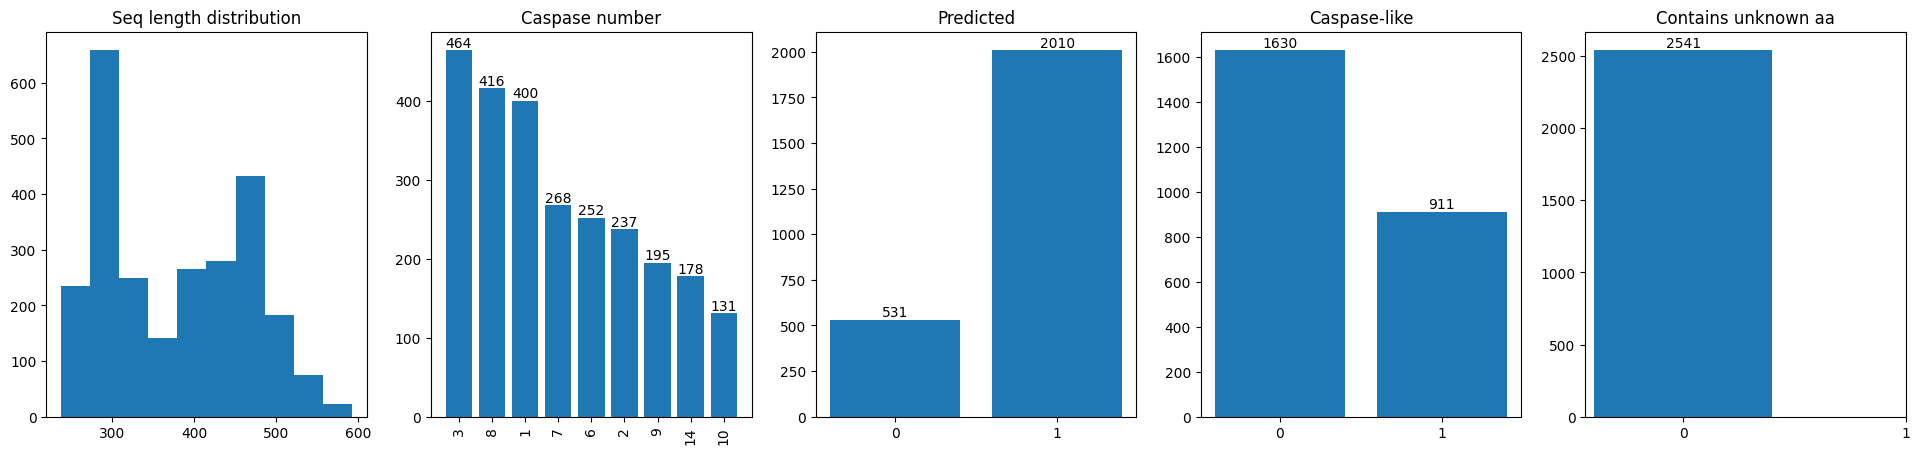

In [48]:
original_df = df
df = df[df["len"] < 600]
print(f"Removed {len(df) - len(df)} sequences based on length")
l = len(df)

df = df[df["contains_unknown_aa"] == False]
print(f"Removed {l - len(df)} sequences containing unknown aminoacids")
l = len(df)

counts = df['caspase'].value_counts()
keep = counts[counts > 100].index
df = df[df['caspase'].isin(keep)]
print(f"Removed {l - len(df)} sequences based on sample availability")

print(f"Total remaining sequences: {len(df)}")

fig = plot_infos(df)
fig.savefig(f"{data_path}info_plots_filtered.png", dpi=300, bbox_inches='tight')
plt.show();

Save dataframes for later reference

In [49]:
original_df.to_csv(f"{data_path}caspase_info_unfiltered.csv", index=False)
df.to_csv(f"{data_path}caspase_info_filtered.csv", index=False)

Save a fasta file containing only the filtered sequences

In [50]:
filtered_fasta_file = os.path.join(data_path, "filtered_caspase_sequences.fasta")
records = []
for _, row in df.iterrows():
    record = SeqRecord(
        Seq(row['sequence']),
        id=row['id'],
        description=f"{row['caspase']} {row['species']}"
    )
    records.append(record)

SeqIO.write(records, filtered_fasta_file, "fasta")
print(f"Saved {len(records)} sequences to {filtered_fasta_file}")

Saved 2541 sequences to 0_reset/data/filtered_caspase_sequences.fasta
